In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colrs

from pyspark.sql import SparkSession
import pyspark.sql.functions as spark_functions
import pyspark.sql.types as spark_types
from pyspark.sql.functions import col, pandas_udf, PandasUDFType,udf,broadcast

In [3]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['CMU Serif Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 16

In [2]:
USER = os.getlogin()
WORKING_DIR = f'/home/{USER}/data/Land_use'
DATA_DIR = f'{WORKING_DIR}/data'
METROPOLES_SHAPE = f'{DATA_DIR}/cities'
IMG_DIR = f'{WORKING_DIR}/images'

In [4]:
spark = SparkSession.builder\
    .master('spark://santiago:7077')\
    .appName('Land use - RCA median week')\
    .config('spark.network.timeout', 300)\
    .config('spark.dynamicAllocation.enabled', 'true')\
    .config('spark.shuffle.service.enabled', 'true')\
    .config('spark.dynamicAllocation.initialExecutors', 1)\
    .config('spark.dynamicAllocation.maxExecutors', 20)\
    .config('spark.dynamicAllocation.minExecutors', 0)\
    .config('spark.driver.maxResultSize', '120g')\
    .config('spark.executor.cores', 1)\
    .config('spark.executor.memory', '3g')\
    .config('spark.memory.fraction', 0.6)\
    .config('spark.cores.max', 20)\
    .config('spark.executor.memoryOverhead', '8g')\
    .config('spark.driver.memoryOverhead', '8g')\
    .getOrCreate()

spark.conf.set('spark.sql.session.timeZone', 'Europe/Paris')

2023-08-02 16:46:01,289 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-08-02 16:46:01,671 WARN spark.SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
2023-08-02 16:46:02,177 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load Data

### City mask

In [5]:
CITY_NAME = 'Paris'
df_mask = pd.read_pickle(f'{DATA_DIR}/df_masks.pkl')
city_row = df_mask[df_mask['name'] == CITY_NAME].iloc[0]

city_shape = city_row['shape']
city_mask = city_row['mask']
city_left_x = city_row['left_x']
city_bottom_y = city_row['bottom_y']

### Median Week

In [6]:
filename = f'hdfs://santiago:9000/land_use/{CITY_NAME}_median_week_traffic_maps_rca.parquet'
sdf_traffic = spark.read.parquet(filename)
sdf_traffic.show(2)

+-----+-------------------+--------+-----------+--------------------+--------------------+
| city|                app|    time|day_of_week|         traffic_map|     traffic_map_rca|
+-----+-------------------+--------+-----------+--------------------+--------------------+
|Paris|Amazon Web Services|17:00:00|  Wednesday|[[0.0, 0.0, 0.0, ...|[[0.0, 0.0, 0.0, ...|
|Paris|Amazon Web Services|23:30:00|   Thursday|[[0.0, 0.0, 0.0, ...|[[0.0, 0.0, 0.0, ...|
+-----+-------------------+--------+-----------+--------------------+--------------------+
only showing top 2 rows



### Plot one map

/tmp/ipykernel_1728877/2964968785.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap_traffic = cm.get_cmap('RdBu_r').copy()


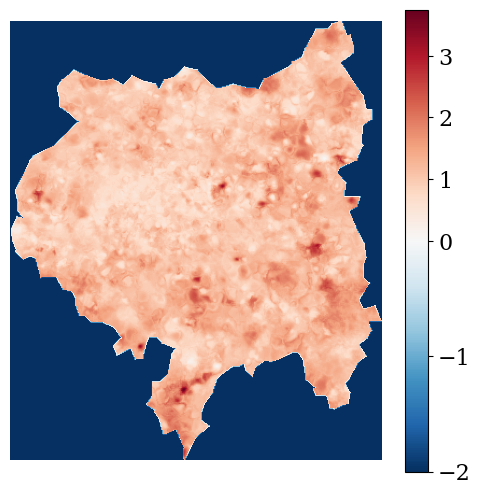

In [7]:
row = sdf_traffic.take(1)
traffic_rca = np.array(list(row[0]['traffic_map_rca']))
traffic_rca[city_mask==0] = -2

v_max = np.max(traffic_rca)
v_min = np.min(traffic_rca)
my_cmap_traffic = cm.get_cmap('RdBu_r').copy()
my_cmap_traffic.set_under('w', 0)
norm_traffic = plt.cm.colors.TwoSlopeNorm(vmin=v_min, vmax=v_max, vcenter=0)

fig = plt.figure(figsize=(6, 6))
plt.imshow(traffic_rca, origin='lower', cmap=my_cmap_traffic, norm=norm_traffic)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## RCA distributions per app (over time)

In [8]:
bins = np.linspace(-1, 5, 100)

schema_histogram = spark_types.ArrayType(spark_types.DoubleType())
# schema_histogram = spark_types.ArrayType(spark_types.IntegerType())

@pandas_udf(schema_histogram)
def traffic_maps_histogram(traffic_maps: pd.Series)-> schema_histogram:
    traffic_maps = traffic_maps.apply(lambda traffic_map: np.array(list(traffic_map)))
    traffic_maps = traffic_maps.apply(lambda traffic_map: traffic_map[ city_mask == 1 ])
    distributions = [ np.histogram(traffic_map, bins=bins)[0] for traffic_map in traffic_maps ]
    distributions = np.array(distributions)
    distribution = distributions.sum(axis=0)

    return distribution.tolist()

In [26]:
sdf_traffic_map_rca_distribution = sdf_traffic.groupBy('city', 'app').agg(traffic_maps_histogram('traffic_map_rca').alias('distribution'))
# sdf_traffic_map_rca_distribution.show(2)

df_traffic_map_rca_distribution = sdf_traffic_map_rca_distribution.toPandas()
df_traffic_map_rca_distribution.sort_values(by=['app'], inplace=True)
df_traffic_map_rca_distribution.head(2)

,city,app,distribution
43,Paris,Amazon Web Services,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Paris,Apple App Store,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


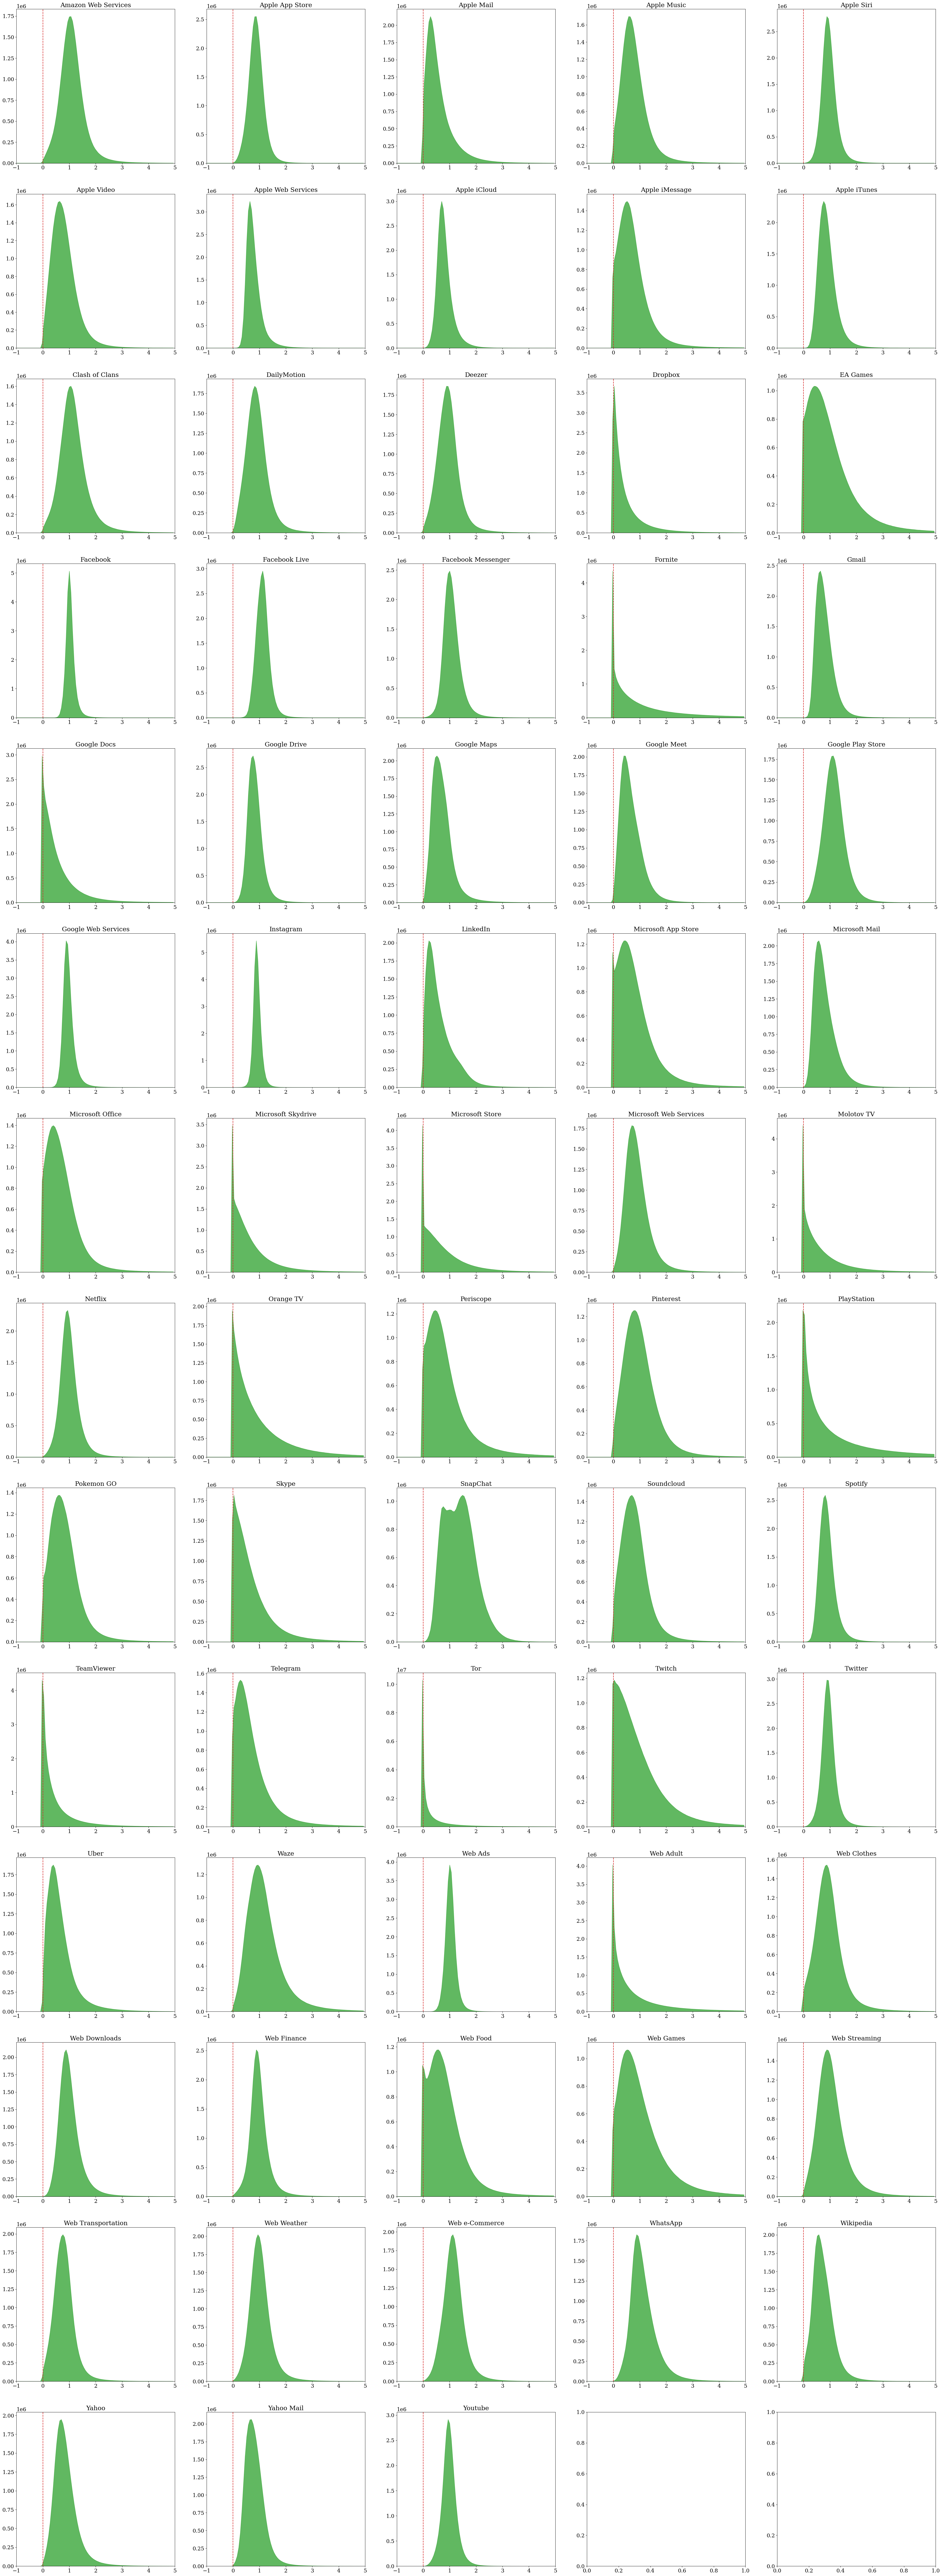

2023-08-02 16:23:56,302 WARN storage.BlockManagerMasterEndpoint: No more replicas available for broadcast_25_python !


In [27]:
fig, axs = plt.subplots(14, 5, figsize=(50, 140))
axs = axs.flatten()

for index, row in enumerate(df_traffic_map_rca_distribution.to_dict('records')):
    ax = axs[index]
    if index > 68:
        ax.set_axis('off')
        continue

    app, distribution = row['app'], row['distribution']
    ax.set_title(app)
    distribution = np.array(distribution)

    ax.fill_between(bins[:-1], distribution, color='tab:green', alpha=0.75)
    ax.axvline(x=0, color='tab:red', linestyle='--')

    ax.set_xlim(-1, 5)
    ax.set_ylim(bottom=0)

plt.show()

## Save to Pandas

In [9]:
sdf_traffic_rca = sdf_traffic.select('city', 'app', 'time', 'day_of_week', 'traffic_map_rca')
sdf_traffic_rca.show(2)

+-----+-------------------+--------+-----------+--------------------+
| city|                app|    time|day_of_week|     traffic_map_rca|
+-----+-------------------+--------+-----------+--------------------+
|Paris|Amazon Web Services|17:00:00|  Wednesday|[[0.0, 0.0, 0.0, ...|
|Paris|Amazon Web Services|23:30:00|   Thursday|[[0.0, 0.0, 0.0, ...|
+-----+-------------------+--------+-----------+--------------------+
only showing top 2 rows



In [10]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day_of_week in days_of_week:
    sdf_traffic_rca_day = sdf_traffic_rca.filter(sdf_traffic_rca['day_of_week'] == day_of_week)
    df_traffic_rca_day = sdf_traffic_rca_day.toPandas()
    df_traffic_rca_day['traffic_map_rca'] = df_traffic_rca_day.apply(lambda row: np.array(row['traffic_map_rca'], dtype=np.float16), axis=1)
    df_traffic_rca_day.to_pickle(f'{DATA_DIR}/df_traffic_rca_day_{day_of_week}.pkl')
    
    del df_traffic_rca_day
    
    print(f'Day of week: {day_of_week} Done!')

Day of week: Monday Done!


Day of week: Tuesday Done!


Day of week: Wednesday Done!


Day of week: Thursday Done!


Day of week: Friday Done!


Day of week: Saturday Done!


Day of week: Sunday Done!


In [ ]:
# day = 'Saturday'
# sdf_traffic_srca_day = sdf_traffic_srca.filter(sdf_traffic_srca['day_of_week'] == day)
# df_traffic_srca_day = sdf_traffic_srca_day.toPandas()
# df_traffic_srca_day['traffic_map_srca'] = df_traffic_srca_day.apply(lambda row: np.array(row['traffic_map_srca'], dtype=np.float16), axis=1)
# df_traffic_srca_day.to_pickle(f'{DATA_DIR}/df_traffic_srca_day_{day}_latest.pkl')
